# 피마 인디언 당뇨병 예측
https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?select=diabetes.csv

머신러닝 예측 모델을 수립하고, 평가 지표를 적용.

피마 인디언 당뇨병 데이터셋은 다음 feature로 구성.
* Pregnancies : 임신 횟수
* Glucose : 포도당 부하 검사 수치
* BloodPressure : 혈압(mm Hg)
* SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
* Insulin : 혈청 인슐린(mu U/ml)
* BMI : 체질량지수 (체중(kg)/키(m**2))
* DiabetesPedigreeFunction : 당뇨 내력 가중치 값
* Age : 나이
* Outcome : 클래스 결정 값(0 or 1)

## diabetes.csv 로딩 및 데이터 확인

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer

diabetes_data = pd.read_csv('./diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

# 전체 768개의 데이터 중에서 Negative(0)이 500개
# Positive(1)이 268개로 Negative가 상대적으로 많다

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


## feature type과 Null 개수 파악

In [3]:
diabetes_data.info()

# Null값은 없으며
# Feature type은 모두 숫자형이다.
# 임신 횟수, 나이와 같은 숫자형 feature와 당뇨 검사 수치 feature로 구성된 특징으로 볼 때,
# 별도의 feature encoding은 필요하지 않아 보임.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## 로지스틱 회귀를 이용한 예측 모델 생성

In [4]:
def get_clf_eval(y_test, pred=None, pred_proba=None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차 행렬")
    print(confusion)
    print("정확도 : {0: .4f}, 정밀도 : {1: .4f}, 재현율 : {2: .4f}, F1 : {3: .4f}, AUC : {4: .4f}" .format(accuracy, precision, recall, f1, roc_auc))


In [5]:
# Feature dataset X, Label dataset y 추출
# 맨 끝이 'Outcome' Column으로 레이블 값임. Column 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도 :  0.7727, 정밀도 :  0.7111, 재현율 :  0.5926, F1 :  0.6465, AUC :  0.8083


## 재현율 성능에 초점

전체 데이터의 65%가 Negative이므로 정확도보다는 재현율 성능에 조금 더 초점을 맞춰야 한다. <br>
먼저 정밀도 재현율 곡선을 보고 임계값별 정밀도와 재현율 값의 변화를 확인한다. <br>
이를 위해 precision_recall_curve_plot() 함수를 이용한다 <br>

In [6]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test, pred_proba_c1) :
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도와 재현율 값으로 각각 Plot (정밀도는 점선)
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0 : threshold_boundary], ls='--', label='precision')
    plt.plot(thresholds, recalls[0 : threshold_boundary], label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # x축, y축 label과 legend, grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show();

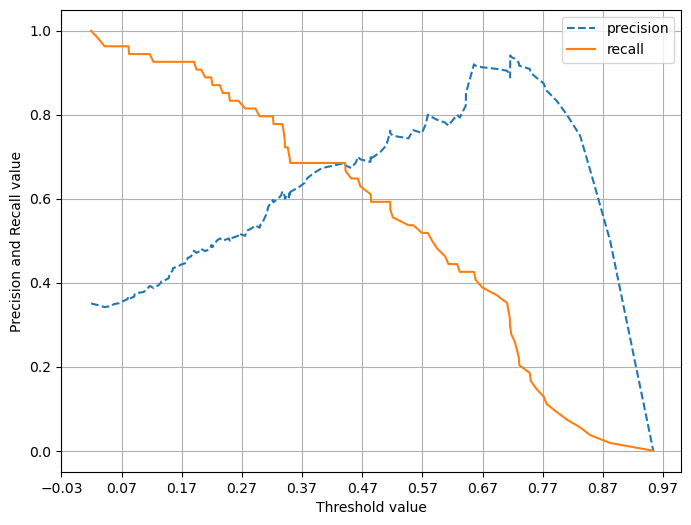

In [7]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

# 재현율 곡선을 보면 임계값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것 같다.
# 하지만 두 개의 지표 모두 0.7이 안 되는 수치로 보인다. 여전히 두 지표의 값이 낮다.
# 임계값을 인위적으로 조작하기 전에 다시 데이터 값을 점검한다.
# 먼저 원본 데이터 DataFrame의 describe() method를 호출해 Feature 값의 분포도를 살펴본다

In [8]:
diabetes_data.describe()

# diabetes_data.describe() 데이터 값을 보면 min 값이 0으로 돼있는 Feature가 매우 많다.
# 예를 들어 Glucose Feature는 포도당 수치인데 min 값이 0인 것은 말이 되지 않다.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


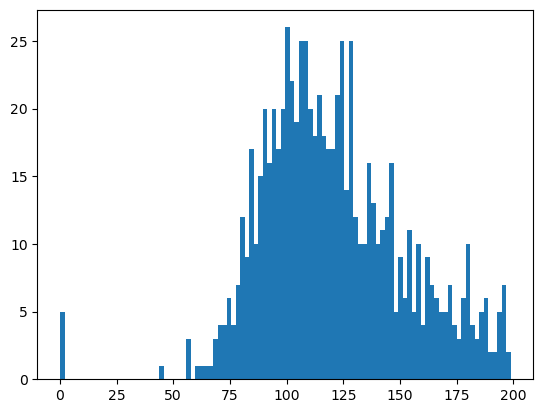

In [9]:
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show()

# Glucose Feature의 히스토그램을 확인해 보면 0값이 일정 수준 존재하는 것을 알 수 있다.
# min 값이 0으로 돼 있는 Feature에 대해 0값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인해야 한다.
# 확인할 Feature는 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'이다.

In [10]:
# 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI' Feature들에 대해
# 0 값이 전체 데이터 건수 대비 몇 퍼센트 비율로 존재하는지 확인

# 0 값을 검사할 Feature명 list
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# Feature 별로 반복하며 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features :
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('[{0}] 0 값의 개수 :  {1}, {2: .2f}%' .format(feature, zero_count, 100*zero_count/total_count)) 

# 'SkinThickness', 'Insulin'의 0 값은 전체의 29.56%, 48.7%로 매우 많다.
# 이 데이터들을 삭제할 경우에는 학습을 효과적으로 수행하기 어렵기 때문에 위 Feature의 0 값을 평균값으로 대체한다.

[Glucose] 0 값의 개수 :  5,  0.65%
[BloodPressure] 0 값의 개수 :  35,  4.56%
[SkinThickness] 0 값의 개수 :  227,  29.56%
[Insulin] 0 값의 개수 :  374,  48.70%
[BMI] 0 값의 개수 :  11,  1.43%


## 0 값을 평균값으로 대체

In [11]:
# zero_features list 내부에 저장된 개별 Feature들에 대해서 0 값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

## 숫자 데이터에 scaling 및 로지스틱 회귀를 적용한 성능 평가 지표 확인

In [12]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 Feature dataset에 일괄적으로 Scaling 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

# 0값 -> 평균값 으로 대체, Scaling을 통해 성능 수치가 일정 수준 개선됐다.
# 하지만 여전히 재현율 수치는 개선이 필요해 보인다.
# 분류 결정 임계값을 변화시키며 재현율 값의 성능 수치가 어느 정도 개선되는지 확인해야 한다.

오차 행렬
[[90 10]
 [21 33]]
정확도 :  0.7987, 정밀도 :  0.7674, 재현율 :  0.6111, F1 :  0.6804, AUC :  0.8433


## 분류 결정 임계값 변화에 따른 재현율 값의 성능 수치 확인

In [13]:
def get_eval_by_threshold(y_test, pred_prob_c1, thresholds) :
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_prob_c1)
        custom_predict = binarizer.transform(pred_prob_c1)
        print("임계값 : ", custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_prob_c1)
        print("")

In [14]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


# 정확도와 정밀도를 희생하고 재현율을 높이는 데 가장 좋은 임계값은 0.3으로 보인다.
# 하지만 정밀도가 0.5658로 매우 낮아졌으니 극단적인 선택으로 보인다.

# 임계값이 0.48일 경우, 정확도 :  0.7987, 정밀도 :  0.7447, 재현율 :  0.6481, F1 :  0.6931, AUC :  0.8433

임계값 :  0.3
오차 행렬
[[67 33]
 [11 43]]
정확도 :  0.7143, 정밀도 :  0.5658, 재현율 :  0.7963, F1 :  0.6615, AUC :  0.8433

임계값 :  0.33
오차 행렬
[[72 28]
 [12 42]]
정확도 :  0.7403, 정밀도 :  0.6000, 재현율 :  0.7778, F1 :  0.6774, AUC :  0.8433

임계값 :  0.36
오차 행렬
[[76 24]
 [15 39]]
정확도 :  0.7468, 정밀도 :  0.6190, 재현율 :  0.7222, F1 :  0.6667, AUC :  0.8433

임계값 :  0.39
오차 행렬
[[78 22]
 [16 38]]
정확도 :  0.7532, 정밀도 :  0.6333, 재현율 :  0.7037, F1 :  0.6667, AUC :  0.8433

임계값 :  0.42
오차 행렬
[[84 16]
 [18 36]]
정확도 :  0.7792, 정밀도 :  0.6923, 재현율 :  0.6667, F1 :  0.6792, AUC :  0.8433

임계값 :  0.45
오차 행렬
[[85 15]
 [18 36]]
정확도 :  0.7857, 정밀도 :  0.7059, 재현율 :  0.6667, F1 :  0.6857, AUC :  0.8433

임계값 :  0.48
오차 행렬
[[88 12]
 [19 35]]
정확도 :  0.7987, 정밀도 :  0.7447, 재현율 :  0.6481, F1 :  0.6931, AUC :  0.8433

임계값 :  0.5
오차 행렬
[[90 10]
 [21 33]]
정확도 :  0.7987, 정밀도 :  0.7674, 재현율 :  0.6111, F1 :  0.6804, AUC :  0.8433



## 임계값 0.48로 낮춘 상태에서 다시 예측

In [15]:
# 임계값을 0.48로 설정한 Binarizer 생성

binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 Column값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도 :  0.7987, 정밀도 :  0.7447, 재현율 :  0.6481, F1 :  0.6931, AUC :  0.8433
